#### Imports and Getting the Data

In [1]:
!pip install yfinance

In [2]:
!pip uninstall gdown -y && pip install gdown
!gdown -V

Found existing installation: gdown 5.2.0
Uninstalling gdown-5.2.0:
  Successfully uninstalled gdown-5.2.0
gdown 5.2.0 at /usr/local/lib/python3.11/dist-packages


In [3]:
# IMPORTS
import numpy as np
import pandas as pd

#Fin Data Sources
import yfinance as yf
import pandas_datareader as pdr

#Data viz
import plotly.graph_objs as go
import plotly.graph_objects as go
import plotly.express as px

import time
from datetime import date

# for graphs
import matplotlib.pyplot as plt

# For Decision Trees
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score


In [4]:
pd.set_option('display.max_rows', None)

#### Data from the previous week for the 33 largest stocks by Market Cap

In [5]:
!gdown https://drive.google.com/file/d/1mb0ae2M5AouSDlqcUnIwaHq7avwGNrmB/view?usp=sharing --fuzzy -O /content/

Downloading...
From (original): https://drive.google.com/uc?id=1mb0ae2M5AouSDlqcUnIwaHq7avwGNrmB
From (redirected): https://drive.google.com/uc?id=1mb0ae2M5AouSDlqcUnIwaHq7avwGNrmB&confirm=t&uuid=55cbcfe0-1be4-4e76-9237-13b26c052a62
To: /content/stocks_df_combined_2025_06_13.parquet.brotli
100% 130M/130M [00:02<00:00, 59.5MB/s]


In [6]:
# full dataset for 33 stocks
df_full = pd.read_parquet("/content/stocks_df_combined_2025_06_13.parquet.brotli", )

In [7]:
df_full.info()

<class 'pandas.core.frame.DataFrame'>
Index: 230262 entries, 0 to 5700
Columns: 203 entries, Open to growth_btc_usd_365d
dtypes: datetime64[ns](3), float64(129), int32(64), int64(5), object(2)
memory usage: 302.2+ MB


In [8]:
df_full.keys()

Index(['Open', 'High', 'Low', 'Close_x', 'Volume', 'Dividends', 'Stock Splits',
       'Ticker', 'Year', 'Month',
       ...
       'growth_brent_oil_7d', 'growth_brent_oil_30d', 'growth_brent_oil_90d',
       'growth_brent_oil_365d', 'growth_btc_usd_1d', 'growth_btc_usd_3d',
       'growth_btc_usd_7d', 'growth_btc_usd_30d', 'growth_btc_usd_90d',
       'growth_btc_usd_365d'],
      dtype='object', length=203)

In [9]:
# growth indicators (but not future growth)
GROWTH = [g for g in df_full.keys() if (g.find('growth_')==0)&(g.find('future')<0)]

In [10]:
OHLCV = ['Open','High','Low','Close','Adj Close_x','Volume']

In [11]:
CATEGORICAL = ['Month', 'Weekday', 'Ticker', 'ticker_type']

In [12]:
TO_PREDICT = [g for g in df_full.keys() if (g.find('future')>=0)]
TO_PREDICT

['growth_future_30d', 'is_positive_growth_30d_future']

In [13]:
TO_DROP = ['Year','Date','index_x', 'index_y', 'index', 'Quarter','Adj Close_y'] + CATEGORICAL + OHLCV
TO_DROP

['Year',
 'Date',
 'index_x',
 'index_y',
 'index',
 'Quarter',
 'Adj Close_y',
 'Month',
 'Weekday',
 'Ticker',
 'ticker_type',
 'Open',
 'High',
 'Low',
 'Close',
 'Adj Close_x',
 'Volume']

In [14]:
df_full['ln_volume'] = df_full.Volume.replace(0, np.nan).apply(np.log)

In [15]:
# manually defined features
CUSTOM_NUMERICAL = ['SMA10', 'SMA20', 'growing_moving_average', 'high_minus_low_relative','volatility', 'ln_volume']

In [16]:
# All Supported Ta-lib indicators: https://github.com/TA-Lib/ta-lib-python/blob/master/docs/funcs.md

TECHNICAL_INDICATORS = ['adx', 'adxr', 'apo', 'aroon_1','aroon_2', 'aroonosc',
 'bop', 'cci', 'cmo','dx', 'macd', 'macdsignal', 'macdhist', 'macd_ext',
 'macdsignal_ext', 'macdhist_ext', 'macd_fix', 'macdsignal_fix',
 'macdhist_fix', 'mfi', 'minus_di', 'mom', 'plus_di', 'dm', 'ppo',
 'roc', 'rocp', 'rocr', 'rocr100', 'rsi', 'slowk', 'slowd', 'fastk',
 'fastd', 'fastk_rsi', 'fastd_rsi', 'trix', 'ultosc', 'willr',
 'ad', 'adosc', 'obv', 'atr', 'natr', 'ht_dcperiod', 'ht_dcphase',
 'ht_phasor_inphase', 'ht_phasor_quadrature', 'ht_sine_sine', 'ht_sine_leadsine',
 'ht_trendmod', 'avgprice', 'medprice', 'typprice', 'wclprice']

In [17]:
TECHNICAL_PATTERNS = [g for g in df_full.keys() if g.find('cdl')>=0]
print(f'Technical patterns count = {len(TECHNICAL_PATTERNS)}, examples = {TECHNICAL_PATTERNS[0:5]}')

Technical patterns count = 61, examples = ['cdl2crows', 'cdl3blackrows', 'cdl3inside', 'cdl3linestrike', 'cdl3outside']


In [18]:
MACRO = ['gdppot_us_yoy', 'gdppot_us_qoq', 'cpi_core_yoy', 'cpi_core_mom', 'FEDFUNDS',
 'DGS1', 'DGS5', 'DGS10']


In [19]:
NUMERICAL = GROWTH + TECHNICAL_INDICATORS + TECHNICAL_PATTERNS + CUSTOM_NUMERICAL + MACRO

In [20]:
# CHECK: NO OTHER INDICATORS LEFT
OTHER = [k for k in df_full.keys() if k not in OHLCV + CATEGORICAL + NUMERICAL + TO_DROP]
OTHER

['Close_x',
 'Dividends',
 'Stock Splits',
 'growth_future_30d',
 'is_positive_growth_30d_future',
 'Close_y']

In [21]:
df = df_full[df_full.Date>='2000-01-01']
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 191795 entries, 3490 to 5700
Columns: 204 entries, Open to ln_volume
dtypes: datetime64[ns](3), float64(130), int32(64), int64(5), object(2)
memory usage: 253.1+ MB


In [22]:
df[NUMERICAL].info()

<class 'pandas.core.frame.DataFrame'>
Index: 191795 entries, 3490 to 5700
Columns: 184 entries, growth_1d to DGS10
dtypes: float64(121), int32(62), int64(1)
memory usage: 225.3 MB


#### Generating Dummies

In [23]:
CATEGORICAL

['Month', 'Weekday', 'Ticker', 'ticker_type']

In [24]:
df.loc[:, 'Month'] = df['Month'].dt.strftime('%B')
df.loc[:, 'Weekday'] = df['Weekday'].astype(str)

/tmp/ipython-input-24-690867338.py:1: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '['January' 'January' 'January' ... 'June' 'June' 'June']' has dtype incompatible with datetime64[ns], please explicitly cast to a compatible dtype first.
  df.loc[:, 'Month'] = df['Month'].dt.strftime('%B')
/tmp/ipython-input-24-690867338.py:2: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '['0' '1' '2' ... '2' '3' '4']' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  df.loc[:, 'Weekday'] = df['Weekday'].astype(str)


### Question 1: Dummies for Month and Week-of-Month


In [25]:
# #Week of Month
df.loc[:, 'week_of_month'] = df['Date'].dt.day.apply(lambda d: (d - 1) // 7 + 1)

/tmp/ipython-input-25-1288263966.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, 'week_of_month'] = df['Date'].dt.day.apply(lambda d: (d - 1) // 7 + 1)


In [26]:
# Creating the new category month_wom
df.loc[:, 'month_wom'] = df['Month'] + '_w' + df['week_of_month'].astype(str)

/tmp/ipython-input-26-569559257.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, 'month_wom'] = df['Month'] + '_w' + df['week_of_month'].astype(str)


In [27]:
# Updating categorical
CATEGORICAL = ['Month', 'Weekday', 'Ticker', 'ticker_type', 'month_wom']

In [28]:
# Creating the dummy variables
dummy_variables = pd.get_dummies(df[CATEGORICAL], dtype='int32')

In [29]:
DUMMIES = dummy_variables.columns.to_list()

In [30]:
# Merge into original df
df_with_dummies = pd.concat([df, dummy_variables], axis=1)

In [31]:
corr = df_with_dummies[NUMERICAL + DUMMIES + TO_PREDICT].corr()
corr_target = corr['is_positive_growth_30d_future'].drop('is_positive_growth_30d_future')

In [32]:
# Just seperating the Month of Week dummies
month_wom_dummies = [col for col in DUMMIES if col.startswith('month_wom')]
month_wom_corr = corr_target[month_wom_dummies].copy()

In [33]:
# Create DataFrame with absolute correlations
month_wom_corr_df = pd.DataFrame({
    'feature': month_wom_corr.index,
    'correlation': month_wom_corr.values,
})
month_wom_corr_df['abs_corr'] = month_wom_corr_df['correlation'].abs()

In [34]:
# Sort by absolute correlation
month_wom_corr_df_sorted = month_wom_corr_df.sort_values(by='abs_corr', ascending=False)

In [35]:
month_wom_corr_df_sorted.head(5)

,feature,correlation,abs_corr
53,month_wom_October_w4,0.024968,0.024968
47,month_wom_November_w3,0.022097,0.022097
46,month_wom_November_w2,0.018822,0.018822
21,month_wom_January_w2,-0.018327,0.018327
52,month_wom_October_w3,0.017734,0.017734


In [36]:
print(f"Most correlated dummy: {month_wom_corr_df_sorted.iloc[0]}")
print(f"Absolute correlation: {round(month_wom_corr_df_sorted.iloc[0]['abs_corr'], 3)}")

Most correlated dummy: feature        month_wom_October_w4
correlation                0.024968
abs_corr                   0.024968
Name: 53, dtype: object
Absolute correlation: 0.025


### Temporal split of ~25 years of data (by date)

In [37]:
def temporal_split(df, min_date, max_date, train_prop=0.7, val_prop=0.15, test_prop=0.15):
    """
    Splits a DataFrame into three buckets based on the temporal order of the 'Date' column.

    Args:
        df (DataFrame): The DataFrame to split.
        min_date (str or Timestamp): Minimum date in the DataFrame.
        max_date (str or Timestamp): Maximum date in the DataFrame.
        train_prop (float): Proportion of data for training set (default: 0.6).
        val_prop (float): Proportion of data for validation set (default: 0.2).
        test_prop (float): Proportion of data for test set (default: 0.2).

    Returns:
        DataFrame: The input DataFrame with a new column 'split' indicating the split for each row.
    """
    # Define the date intervals
    train_end = min_date + pd.Timedelta(days=(max_date - min_date).days * train_prop)
    val_end = train_end + pd.Timedelta(days=(max_date - min_date).days * val_prop)

    # Assign split labels based on date ranges
    split_labels = []
    for date in df['Date']:
        if date <= train_end:
            split_labels.append('train')
        elif date <= val_end:
            split_labels.append('validation')
        else:
            split_labels.append('test')

    # Add 'split' column to the DataFrame
    df['split'] = split_labels

    return df


In [38]:
min_date_df = df_with_dummies.Date.min()
max_date_df = df_with_dummies.Date.max()

df_with_dummies = temporal_split(df_with_dummies,
                                 min_date = min_date_df,
                                 max_date = max_date_df)

In [39]:
df_with_dummies['split'].value_counts()/len(df_with_dummies)

,count
split,
train,0.676399
test,0.163758
validation,0.159843


In [40]:
new_df = df_with_dummies.copy()

In [41]:
new_df.groupby(by='split')['growth_future_30d'].describe()

,count,mean,std,min,25%,50%,75%,max
split,,,,,,,,
test,30418.0,1.019899,0.102172,0.580332,0.955986,1.016057,1.077950,1.648934
train,129730.0,1.023864,0.123190,0.246131,0.960248,1.020585,1.083310,5.179689
validation,30657.0,1.029596,0.099908,0.461847,0.973991,1.030784,1.086687,1.783610


In [42]:
new_df.groupby(['split'])['Date'].agg({'min','max','count'})

,min,count,max
split,,,
test,2021-08-20,31408,2025-06-13
train,2000-01-03,129730,2017-10-25
validation,2017-10-26,30657,2021-08-19


In [43]:
# generate manual predictions
# Let's label all prediction features with prefix "pred"
new_df['pred0_manual_cci'] = (new_df.cci>200).astype(int)
new_df['pred1_manual_prev_g1'] = (new_df.growth_30d>1).astype(int)
new_df['pred2_manual_prev_g1_and_snp'] = ((new_df['growth_30d'] > 1) & (new_df['growth_snp500_30d'] > 1)).astype(int)

In [44]:
PREDICTIONS = [k for k in new_df.keys() if k.startswith('pred')]

In [45]:
# generate columns is_correct_
for pred in PREDICTIONS:
  part1 = pred.split('_')[0] # first prefix before '_'
  new_df[f'is_correct_{part1}'] =  (new_df[pred] == new_df.is_positive_growth_30d_future).astype(int)


In [46]:
IS_CORRECT =  [k for k in new_df.keys() if k.startswith('is_correct_')]
IS_CORRECT

['is_correct_pred0', 'is_correct_pred1', 'is_correct_pred2']

In [47]:
# define "Precision" for ALL predictions on a Test dataset (~4 last years of trading)
for i,column in enumerate(IS_CORRECT):
  prediction_column = PREDICTIONS[i]
  is_correct_column = column
  filter = (new_df.split=='test') & (new_df[prediction_column]==1)
  print(f'Prediction column:{prediction_column} , is_correct_column: {is_correct_column}')
  print(new_df[filter][is_correct_column].value_counts())
  print(new_df[filter][is_correct_column].value_counts()/len(new_df[filter]))

  print('---------')



Prediction column:pred0_manual_cci , is_correct_column: is_correct_pred0
is_correct_pred0
1    443
0    351
Name: count, dtype: int64
is_correct_pred0
1    0.557935
0    0.442065
Name: count, dtype: float64
---------
Prediction column:pred1_manual_prev_g1 , is_correct_column: is_correct_pred1
is_correct_pred1
1    9748
0    8243
Name: count, dtype: int64
is_correct_pred1
1    0.541826
0    0.458174
Name: count, dtype: float64
---------
Prediction column:pred2_manual_prev_g1_and_snp , is_correct_column: is_correct_pred2
is_correct_pred2
1    6984
0    6383
Name: count, dtype: int64
is_correct_pred2
1    0.522481
0    0.477519
Name: count, dtype: float64
---------


1.4.1) Define dataframes AND perform data cleaning

In [48]:
# Decision Tree doesn't like too large and inf. values
import numpy as np

def remove_infinite_values(X):
    """
    Remove infinite values from the input array.

    Parameters:
    - X: Input array (NumPy array or array-like)

    Returns:
    - Array with infinite values removed
    """
    return X[np.isfinite(X).all(axis=1)]

In [49]:
# Split the data into training and testing sets based on the split date
features_list = NUMERICAL+DUMMIES
to_predict = 'is_positive_growth_30d_future'

train_df = new_df[new_df.split.isin(['train','validation'])].copy(deep=True)
test_df = new_df[new_df.split.isin(['test'])].copy(deep=True)

# ONLY numerical Separate features and target variable for training and testing sets
# need Date and Ticker later when merging predictions to the dataset
X_train = train_df[features_list+[to_predict,'Date','Ticker']]
X_test = test_df[features_list+[to_predict,'Date','Ticker']]

print(f'length: X_train {X_train.shape},  X_test {X_test.shape}')


length: X_train (160387, 302),  X_test (31408, 302)


In [50]:
# Can't have +-inf values . E.g. ln(volume)=-inf when volume==0 => substitute with 0

# Disable SettingWithCopyWarning
pd.options.mode.chained_assignment = None  # default='warn'

X_train.replace([np.inf, -np.inf], np.nan, inplace=True)
X_test.replace([np.inf, -np.inf], np.nan, inplace=True)

# Need to fill NaNs somehow
X_train.fillna(0, inplace=True)
X_test.fillna(0, inplace=True)

print(f'length: X_train_imputed {X_train.shape},  X_test_imputed {X_test.shape}')


length: X_train_imputed (160387, 302),  X_test_imputed (31408, 302)


In [51]:
X_train_imputed = X_train
X_test_imputed = X_test

In [52]:
y_train = X_train_imputed[to_predict]
y_test = X_test_imputed[to_predict]

# remove y_train, y_test from X_ dataframes
del X_train_imputed[to_predict]
del X_test_imputed[to_predict]

In [53]:
# estimation/fit function (using dataframe of features X and what to predict y) --> optimising total accuracy
# max_depth is hyperParameter
def fit_decision_tree(X, y, max_depth=20):
# Initialize the Decision Tree Classifier
  clf = DecisionTreeClassifier(max_depth=max_depth,random_state=42)

  # Fit the classifier to the training data
  clf.fit(X, y)
  return clf, X.columns


In [54]:
clf_10, train_columns = fit_decision_tree(X=X_train_imputed.drop(['Date','Ticker'],axis=1),
                           y=y_train,
                           max_depth=10)

#### Inference for a Decision Tree

In [55]:
def predict_decision_tree(clf:DecisionTreeClassifier, df_X:pd.DataFrame, y_true: pd.Series):
  # Predict the target variable on the test data
  y_pred = clf.predict(df_X)

  max_depth = clf.tree_.max_depth
  # Print the maximum depth
  print("Maximum depth of the decision tree:", max_depth)

  # Calculate the accuracy/precision of the model
  accuracy = accuracy_score(y_test, y_pred)
  precision = precision_score(y_test, y_pred)
  print(f'Accuracy ={accuracy}, precision = {precision}')

  # resulting df
  result_df = pd.concat([df_X, y_true, pd.Series(y_pred, index=df_X.index, name='pred_')], axis=1)

  return result_df


In [56]:
pred10 = predict_decision_tree(clf_10, X_test_imputed.drop(['Date','Ticker'],axis=1), y_test)

Maximum depth of the decision tree: 10
Accuracy =0.5571510443199185, precision = 0.5889278426037361


#### Features Importance and Tree Visualisation of top levels (for clf10)

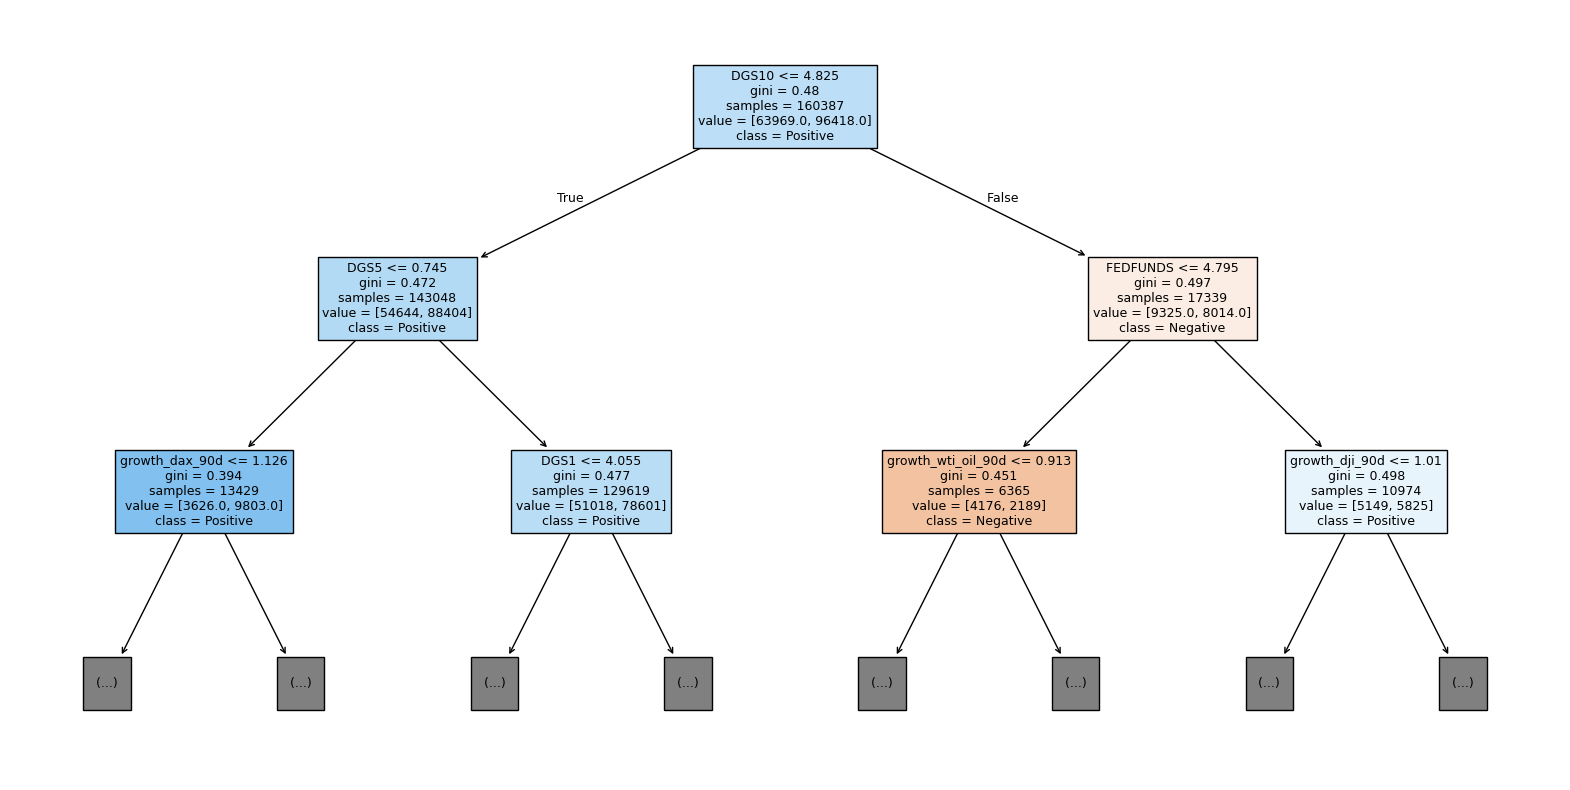

In [57]:
# visualisation: decision tree for a few levels (max_depth variable)
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

# Assuming clf is your trained DecisionTreeClassifier
plt.figure(figsize=(20,10))  # Set the size of the figure
plot_tree(clf_10,
          filled=True,
          feature_names=train_columns,
          class_names=['Negative', 'Positive'],
          max_depth=2)
plt.show()


In [58]:
# Feautures importance function to predict future returns (based on the classifier)
# get feature importance from 'clf' (classifier) and 'train_columns' (column names)

def get_importances(clf, train_columns):
  # Assuming clf is your trained DecisionTreeClassifier
  feature_importance = clf.feature_importances_

  # Assuming X_train is your training features
  feature_names = train_columns

  # Create a DataFrame to store feature importance
  feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})

  # Sort the DataFrame by importance in descending order
  feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

  # Print or display the feature importance DataFrame
  # print(feature_importance_df)
  return feature_importance_df

In [59]:
get_importances(clf_10, train_columns).head(10)

,Feature,Importance
183,DGS10,0.069737
181,DGS1,0.050300
178,cpi_core_yoy,0.045041
35,growth_gold_365d,0.035765
93,ad,0.033934
179,cpi_core_mom,0.033414
16,growth_snp500_90d,0.032243
33,growth_gold_30d,0.029912
41,growth_wti_oil_365d,0.029139
95,obv,0.028833


### Question 2: Define New "Hand" Rules on Macro and Technical Indicator Variables

In [60]:
# Define new prediction rules
new_df['pred3_manual_dgs10_5'] = ((new_df['DGS10'] <= 4.825) & (new_df['DGS5'] <= 0.745)).astype(int)
new_df['pred4_manual_dgs10_fedfunds'] = ((new_df['DGS10'] > 4.825) & (new_df['FEDFUNDS'] <= 4.795)).astype(int)

In [68]:
new_df[['pred4_manual_dgs10_fedfunds','pred3_manual_dgs10_5']].value_counts()

pred4_manual_dgs10_fedfunds  pred3_manual_dgs10_5
0                            0                       172001
                             1                        13429
1                            0                         6365
Name: count, dtype: int64

In [61]:
# Add to predictions list
PREDICTIONS += ['pred3_manual_dgs10_5', 'pred4_manual_dgs10_fedfunds']

In [62]:
# Generate is_correct columns
for pred in ['pred3_manual_dgs10_5', 'pred4_manual_dgs10_fedfunds']:
    part1 = pred.split('_')[0]
    new_df[f'is_correct_{part1}'] = (new_df[pred] == new_df['is_positive_growth_30d_future']).astype(int)
    IS_CORRECT.append(f'is_correct_{part1}')

In [63]:
# Evaluate precision for pred3 and pred4 on test split
for pred in ['pred3_manual_dgs10_5', 'pred4_manual_dgs10_fedfunds']:
    is_correct_col = f'is_correct_{pred.split("_")[0]}'

    # Filter: Only test split + rows where prediction is 1
    test_filter = (new_df['split'] == 'test') & (new_df[pred] == 1)
    num_preds = test_filter.sum()

    if num_preds > 0:
        # Precision = TP / (TP + FP)
        precision = new_df.loc[test_filter, is_correct_col].sum() / num_preds
        print(f"{pred} — Precision: {round(precision, 3)} — Positive Predictions: {num_preds}")
    else:
        print(f"{pred} — No positive predictions on test set.")

pred3_manual_dgs10_5 — No positive predictions on test set.
pred4_manual_dgs10_fedfunds — No positive predictions on test set.


In [64]:
# Look at macro value ranges in the test split
test_macro_stats = new_df[new_df['split'] == 'test'][['DGS10', 'DGS5', 'FEDFUNDS']].describe()
print(test_macro_stats)

              DGS10          DGS5      FEDFUNDS
count  31408.000000  31408.000000  31408.000000
mean       3.584282      3.529760      3.642356
std        0.971163      1.051513      1.971946
min        1.250000      0.770000      0.080000
25%        3.100000      3.180000      2.330000
50%        3.880000      3.930000      4.480000
75%        4.290000      4.240000      5.330000
max        4.980000      4.950000      5.330000


In [65]:
# Count rows satisfying each rule in test set
rule3_mask = (new_df['split'] == 'test') & (new_df['DGS10'] <= 4.825) & (new_df['DGS5'] <= 0.745)
rule4_mask = (new_df['split'] == 'test') & (new_df['DGS10'] > 4.825) & (new_df['FEDFUNDS'] <= 4.795)

print("Rule 3 matches in test:", rule3_mask.sum())
print("Rule 4 matches in test:", rule4_mask.sum())

Rule 3 matches in test: 0
Rule 4 matches in test: 0


In [66]:
test_df = new_df[new_df['split'] == 'test']

# View rows where DGS10 > 4.825
high_dgs10 = test_df[test_df['DGS10'] > 4.825]
print("Rows with DGS10 > 4.825:", len(high_dgs10))

low_ffs = test_df[test_df['FEDFUNDS'] <= 4.795]
print("Rows with FEDFUNDS <= 4.795:", len(low_ffs))

# Now see if any of those also have FEDFUNDS <= 4.795
both_conditions = high_dgs10[high_dgs10['FEDFUNDS'] <= 4.795]
print("Rows with DGS10 > 4.825 and FEDFUNDS <= 4.795:", len(both_conditions))

both_conditions = low_ffs[low_ffs['DGS10'] >= 4.825]
print("Rows with DGS10 > 4.825 and FEDFUNDS <= 4.795:", len(both_conditions))


Rows with DGS10 > 4.825: 355
Rows with FEDFUNDS <= 4.795: 18291
Rows with DGS10 > 4.825 and FEDFUNDS <= 4.795: 0
Rows with DGS10 > 4.825 and FEDFUNDS <= 4.795: 0


### Question 3: Unique Correct Predictions from a 10-Level Decision Tree Classifier (pred5_clf_10)

In [69]:
all_X = new_df[features_list + ['Date', 'Ticker']].copy()
all_X.replace([np.inf, -np.inf], np.nan, inplace=True)
all_X.fillna(0, inplace=True)

In [70]:
# Predict using the existing trained clf_10
new_df['pred5_clf_10'] = clf_10.predict(all_X[features_list])

In [72]:
# Create is_correct_pred5 column
new_df['is_correct_pred5'] = (new_df['pred5_clf_10'] == new_df['is_positive_growth_30d_future']).astype(int)

In [73]:
is_correct_cols = [col for col in new_df.columns if col.startswith('is_correct_') and not col.endswith('pred5')]

In [74]:
new_df['only_pred5_is_correct'] = (
    (new_df['is_correct_pred5'] == 1) &
    (new_df[is_correct_cols].sum(axis=1) == 0)
).astype(int)

In [75]:
# Filter only test set rows where pred5 is uniquely correct
test_unique_correct_count = new_df[(new_df['split'] == 'test') & (new_df['only_pred5_is_correct'] == 1)].shape[0]

print(f"Unique correct predictions by pred5_clf_10 in test set: {test_unique_correct_count}")

Unique correct predictions by pred5_clf_10 in test set: 4503


#### Advanced (Optional)

In [76]:
def compute_unique_correct_mask(df: pd.DataFrame, pred_col: str, compare_pred_cols: list, target_col='is_positive_growth_30d_future'):
    """
    Returns a boolean Series indicating whether 'pred_col' is the only correct prediction
    compared to other predictions in compare_pred_cols.

    Args:
        df: DataFrame containing prediction columns and the true label.
        pred_col: The main prediction column to evaluate (e.g., 'pred5_clf_10').
        compare_pred_cols: List of other prediction column names to compare against (e.g., ['pred0_manual_...', ...]).
        target_col: The ground truth column name (default is 'is_positive_growth_30d_future').

    Returns:
        A boolean Series indicating rows where pred_col is correct and all compare_preds are incorrect.
    """

    # Compute correctness columns on-the-fly
    main_correct = df[pred_col] == df[target_col]

    # Other predictors' correctness
    others_correct = pd.DataFrame({
        col: (df[col] == df[target_col]) for col in compare_pred_cols
    })

    # Return: main is correct AND all others are wrong
    only_main_is_correct = (main_correct) & (others_correct.sum(axis=1) == 0)

    return only_main_is_correct

In [77]:
compare_preds = ['pred0_manual_cci', 'pred1_manual_prev_g1', 'pred2_manual_prev_g1_and_snp',
                 'pred3_manual_dgs10_5', 'pred4_manual_dgs10_fedfunds']

# Apply the function to compute the mask
new_df['only_pred5_is_correct'] = compute_unique_correct_mask(
    new_df,
    pred_col='pred5_clf_10',
    compare_pred_cols=compare_preds
).astype(int)

# Count in test split
count_unique = new_df[(new_df['split'] == 'test') & (new_df['only_pred5_is_correct'] == 1)].shape[0]
print(f"Unique correct predictions by pred5_clf_10 in test set: {count_unique}")


Unique correct predictions by pred5_clf_10 in test set: 4503


### Question 4: Hyperparameter tuning for a Decision Tree

In [79]:
def tune_and_plot_decision_tree_depth(
    X_train, y_train,
    X_test, y_test,
    new_df,
    features_list,
    target_col='is_positive_growth_30d_future'
):
    """
    Tunes DecisionTreeClassifier max_depth from 1 to 20.
    Plots precision vs. depth and returns best model.
    Appends predictions as 'pred6_clf_best' to new_df.
    """
    precision_scores = {}
    best_precision = -1
    best_depth = None
    clf_best = None

    for depth in range(1, 21):
        clf = DecisionTreeClassifier(max_depth=depth, random_state=42)
        clf.fit(X_train, y_train)
        y_pred_test = clf.predict(X_test)

        precision = precision_score(y_test, y_pred_test)
        precision_scores[depth] = precision

        if precision > best_precision:
            best_precision = precision
            best_depth = depth
            clf_best = clf

    # Plotting precision vs. depth
    plt.figure(figsize=(10, 6))
    plt.plot(list(precision_scores.keys()), list(precision_scores.values()), marker='o')
    plt.title('Test Precision vs. Decision Tree Depth')
    plt.xlabel('Max Depth')
    plt.ylabel('Precision on Test Set')
    plt.grid(True)
    plt.xticks(range(1, 21))
    plt.show()

    print(f"\n✅ Best Depth: {best_depth}, Test Precision: {round(best_precision, 3)}")

    # Predict on all data using best classifier
    all_X = new_df[features_list + ['Date', 'Ticker']].copy()
    all_X.replace([np.inf, -np.inf], np.nan, inplace=True)
    all_X.fillna(0, inplace=True)

    new_df['pred6_clf_best'] = clf_best.predict(all_X[features_list])

    return best_depth, precision_scores, clf_best, new_df


In [85]:
y_train = train_df['is_positive_growth_30d_future']
y_test = test_df['is_positive_growth_30d_future']

X_train = X_train_imputed  # already cleaned and dropped target
X_test = X_test_imputed

X_train = X_train.drop(columns=['Date', 'Ticker'], errors='ignore')
X_test = X_test.drop(columns=['Date', 'Ticker'], errors='ignore')

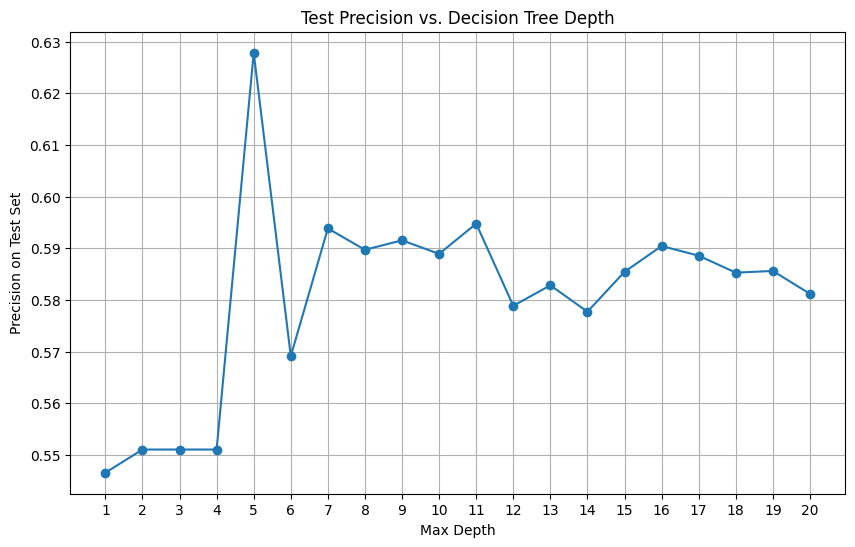


✅ Best Depth: 5, Test Precision: 0.628


In [86]:
best_depth, precision_scores, clf_best, new_df = tune_and_plot_decision_tree_depth(
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test,
    new_df=new_df,
    features_list=features_list
)

In [88]:
PREDICTIONS_ALL = [col for col in new_df.columns if col.startswith('pred')]
print(PREDICTIONS_ALL)

['pred0_manual_cci', 'pred1_manual_prev_g1', 'pred2_manual_prev_g1_and_snp', 'pred3_manual_dgs10_5', 'pred4_manual_dgs10_fedfunds', 'pred5_clf_10', 'pred6_clf_best']


In [89]:
# Filter only TEST rows
df_test = new_df[new_df['split'] == 'test']

# Compare precision of each prediction
for pred_col in PREDICTIONS_ALL:
    if df_test[pred_col].sum() > 0:  # avoid division by zero
        precision = precision_score(df_test['is_positive_growth_30d_future'], df_test[pred_col])
        print(f'{pred_col:<30} Precision: {precision:.3f}')
    else:
        print(f'{pred_col:<30} Precision: N/A (no positive predictions)')

pred0_manual_cci               Precision: 0.558
pred1_manual_prev_g1           Precision: 0.542
pred2_manual_prev_g1_and_snp   Precision: 0.522
pred3_manual_dgs10_5           Precision: N/A (no positive predictions)
pred4_manual_dgs10_fedfunds    Precision: N/A (no positive predictions)
pred5_clf_10                   Precision: 0.589
pred6_clf_best                 Precision: 0.628


### [EXPLORATORY] Question 5: What data is missing?

Maybe we can try introducing **momentum-based composite features** that synthesize existing short- and medium-term growth signals.First, we can compute an **Average Past Momentum** feature as the mean of `growth_7d`, `growth_14d`, and `growth_30d`, which smooths out short-term noise and better captures consistent directional trends in price movement.Second, a **Momentum Diff** feature (`growth_30d - growth_7d`) can help detect acceleration or deceleration in momentum, signaling whether a stock's upward or downward movement is gaining or losing strength over time.Finally, a **Momentum vs Benchmark** feature—defined as the relative performance of a stock against its broader market to check it makes sense.